In [227]:
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading

import numpy as np
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, transforms
from time import time
import os
import tempfile
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    MaskIntensity,
    ThresholdIntensity
)
from monai.utils import set_determinism
import PIL
import matplotlib.pyplot as plt
import math

from custommodels import AutoEnc

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\irose\AppData\Local\Temp\tmpv6xz2p11


In [484]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [485]:
set_determinism(seed=0)
torch.manual_seed(0)
np.random.seed(0)

In [486]:
class_names = sorted(x for x in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

image_files = dict()
num_each = dict()
for class_name in class_names:
    image_files[class_name] = [
        os.path.join(data_dir, class_name, x)
        for x in os.listdir(os.path.join(data_dir, class_name))
    ]
    num_each[class_name] = len(image_files[class_name])

data_len = sum([v for v in num_each.values()])
image_width, image_height = PIL.Image.open(image_files[class_names[0]][0]).size

print(f"Total image count: {data_len}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 12910
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: {'AbdomenCT': 1003, 'BreastMRI': 898, 'CXR': 1003, 'ChestCT': 1003, 'Hand': 1003, 'HeadCT': 8000}


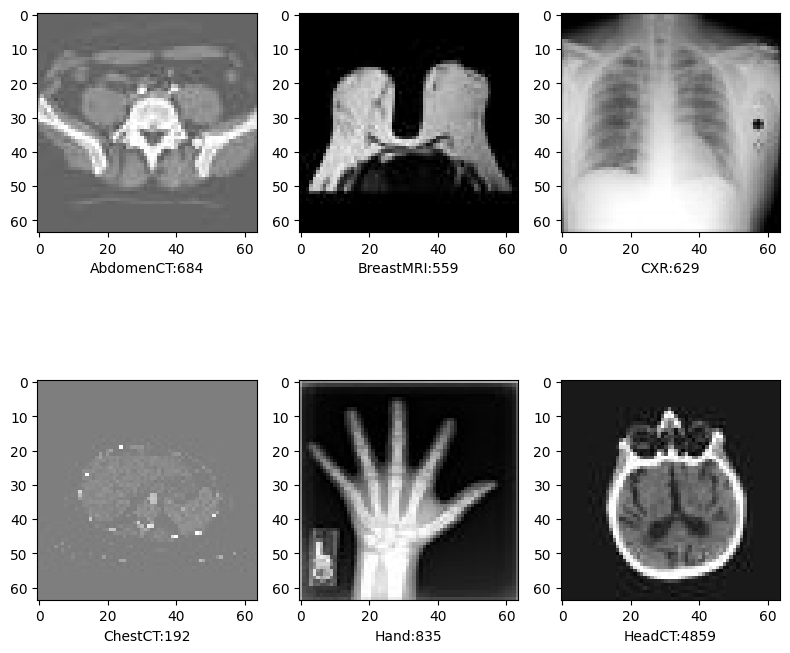

In [487]:
plt.subplots(2,3, figsize=(8, 8))
for i, class_name in enumerate(class_names):
    sel_rand = np.random.randint(num_each[class_name])
    im = PIL.Image.open(image_files[class_name][sel_rand])
    arr = np.array(im)
    plt.subplot(2,3, i + 1)
    plt.xlabel(f"{class_name}:{sel_rand}")
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [488]:
split_dict = dict() #(train,val,test)
split_dict['HeadCT'] = (.6,.2,.2)
split_dict['Hand'] = (0,.1,.1)
split_dict['ChestCT'] = (0,.1,.1)
split_dict['CXR'] = (0,.1,.1)
split_dict['BreastMRI'] = (0,.1,.1)
split_dict['AbdomenCT'] = (0,.1,.1)

train_x = []
val_x = []
test_x = []

for class_name in class_names:
    if class_name in split_dict:
        train_frac,val_frac,test_frac = split_dict[class_name]
        dat_len = num_each[class_name]

        split_indices = np.arange(dat_len)
        np.random.shuffle(split_indices)
        train_indices = split_indices[0:int(dat_len*train_frac)]
        val_indices = split_indices[int(dat_len*train_frac):int(dat_len*train_frac)+int(dat_len*val_frac)]
        test_indices = split_indices[int(dat_len*train_frac)+int(dat_len*val_frac):int(dat_len*train_frac)+int(dat_len*val_frac)+int(dat_len*test_frac)]

        add_train = [image_files[class_name][i] for i in train_indices]
        add_val =  [image_files[class_name][i] for i in val_indices]
        add_test = [image_files[class_name][i] for i in test_indices]
        print(f"For {class_name} added {len(add_train)} train, {len(add_val)} val, {len(add_test)} test.")
        train_x.extend(add_train)
        val_x.extend(add_val)
        test_x.extend(add_test)


For AbdomenCT added 0 train, 100 val, 100 test.
For BreastMRI added 0 train, 89 val, 89 test.
For CXR added 0 train, 100 val, 100 test.
For ChestCT added 0 train, 100 val, 100 test.
For Hand added 0 train, 100 val, 100 test.
For HeadCT added 4800 train, 1600 val, 1600 test.


In [489]:
import h5py
filename = "dsprites-dataset-master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.hdf5"

with h5py.File(filename, "r") as f:
    print("Keys: %s" % f.keys())

    mask_imgs = f['imgs'][()]
    latent_imgs = f['latents']

num_key_frames = len(mask_imgs)
print(f"Number of frames: {num_key_frames}")
mask_indices = np.arange(num_key_frames)
np.random.shuffle(mask_indices)

Keys: <KeysViewHDF5 ['imgs', 'latents']>
Number of frames: 737280


In [490]:
class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, hasMask):
        self.image_files = image_files
        self.hasMask = hasMask
        self.nomask_transforms = Compose([
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
            ]
        )
        self.nomask_transforms = Compose([
                LoadImage(image_only=True),
                EnsureChannelFirst(),
                ScaleIntensity(),
            ]
        )

        self.fakemask = Compose([
                LoadImage(image_only=True),
                ThresholdIntensity(255,True,0),
                EnsureChannelFirst()
            ]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        orig_image = self.nomask_transforms(self.image_files[index])
        if self.hasMask:
            realmask = Compose([
                LoadImage(image_only=True),
                ThresholdIntensity(255,True,1),
                MaskIntensity(mask_imgs[mask_indices[index]]),
                EnsureChannelFirst()
                ]
            )
            mask = realmask(self.image_files[index])
            orig_image = orig_image + mask
        else:
            mask = self.fakemask(self.image_files[index])
        return orig_image,mask


train_ds = MedNISTDataset(train_x, False)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

val_ds = MedNISTDataset(val_x,True)
val_loader = DataLoader(val_ds, batch_size=256)

test_ds = MedNISTDataset(test_x, True)
test_loader = DataLoader(test_ds, batch_size=256)

c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\ipykernel_launcher.py:6: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  


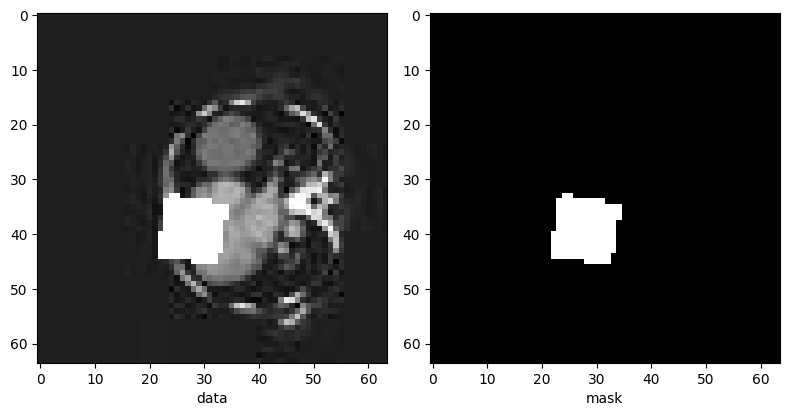

In [492]:
plt.subplots(1,3, figsize=(8, 8))

plt.subplot(1,2,1)
plt.xlabel(f"data")
plt.imshow(val_ds[3][0][0,:,:], cmap="gray", vmin=0, vmax=1)
plt.tight_layout()

plt.subplot(1,2,2)
plt.xlabel(f"mask")
plt.imshow(val_ds[3][1][0,:,:], cmap="gray", vmin=0, vmax=1)
plt.tight_layout()
plt.show()


In [519]:

def compute_dice_curve_recursive(predictions, labels, filename=None, plottitle="DICE Curve", granularity=5):
    scores, threshs = compute_dice_score(predictions, labels, granularity)

    best_score, best_threshold = sorted(zip(scores, threshs), reverse=True)[0]

    min_threshs, max_threshs = min(threshs), max(threshs)
    buffer_range = math.fabs(min_threshs - max_threshs) * 0.02
    x_min, x_max = min(threshs) - buffer_range, max(threshs) + buffer_range
    fig = plt.figure()
    plt.plot(threshs, scores, color='darkorange', lw=2, label='DICE vs Threshold Curve')
    plt.xlim([x_min, x_max])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Thresholds')
    plt.ylabel('DICE Score')
    plt.title(plottitle)
    plt.legend(loc="lower right")
    plt.text(x_max - x_max * 0.01, 1, f'Best dice score at {best_threshold:.5f} with {best_score:.4f}', horizontalalignment='right',
                           verticalalignment='top')
    plt.show()

    # save a pdf to disk
    if filename:
        fig.savefig(filename)

    bestthresh_idx = np.argmax(scores)
    return scores[bestthresh_idx], threshs[bestthresh_idx]

def dice(P, G):
    psum = np.sum(P.flatten())
    gsum = np.sum(G.flatten())
    pgsum = np.sum(np.multiply(P.flatten(), G.flatten()))
    score = (2 * pgsum) / (psum + gsum)
    return score

def xfrange(start, stop, step):
    i = 0
    while start + i * step < stop:
        yield start + i * step
        i += 1

def compute_dice_score(predictions, labels, granularity):
    def inner_compute_dice_curve_recursive(start, stop, decimal):
        _threshs = []
        _scores = []
        had_recursion = False

        if decimal == granularity:
            return _threshs, _scores

        for i, t in enumerate(xfrange(start, stop, (1.0 / (10.0 ** decimal)))):
            score = dice(np.where(predictions > t, 1, 0), labels)
            if i >= 2 and score <= _scores[i - 1] and not had_recursion:
                _subthreshs, _subscores = inner_compute_dice_curve_recursive(_threshs[i - 2], t, decimal + 1)
                _threshs.extend(_subthreshs)
                _scores.extend(_subscores)
                had_recursion = True
            _scores.append(score)
            _threshs.append(t)

        return _threshs, _scores

    threshs, scores = inner_compute_dice_curve_recursive(0, 1.0, 1)
    sorted_pairs = sorted(zip(threshs, scores))
    threshs, scores = list(zip(*sorted_pairs))
    return scores, threshs

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import csv
def compute_prc(predictions, labels, filename=None, plottitle="Precision-Recall Curve"):
    precisions, recalls, thresholds = precision_recall_curve(labels.astype(int), predictions)
    auprc = average_precision_score(labels.astype(int), predictions)

    fig = plt.figure()
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'{plottitle} (area = {auprc:.2f}.)')
    plt.show()

    # save a pdf to disk
    if filename:
        fig.savefig(filename)

        with open(filename + ".csv", mode="w") as csv_file:
            fieldnames = ["Precision", "Recall"]
            writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
            writer.writeheader()
            for i in range(len(precisions)):
                writer.writerow({"Precision": precisions[i], "Recall": recalls[i]})

    return auprc, precisions, recalls, thresholds


def compute_roc(predictions, labels, filename=None, plottitle="ROC Curve"):
    _fpr, _tpr, _ = roc_curve(labels.astype(int), predictions)
    roc_auc = auc(_fpr, _tpr)

    fig = plt.figure()
    plt.plot(_fpr, _tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plottitle)
    plt.legend(loc="lower right")
    plt.show()

    # save a pdf to disk
    if filename:
        fig.savefig(filename)

    return roc_auc, _fpr, _tpr, _

In [532]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEnc().to(device)


loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), 5e-4)
max_epochs = 4
val_interval = 1
auc_metric = ROCAUCMetric()

c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------
epoch 1/4
1/19, train_loss: 0.3580
2/19, train_loss: 0.3164
3/19, train_loss: 0.2720
4/19, train_loss: 0.2395
5/19, train_loss: 0.2053
6/19, train_loss: 0.1973
7/19, train_loss: 0.1765
8/19, train_loss: 0.1662
9/19, train_loss: 0.1602
10/19, train_loss: 0.1438
11/19, train_loss: 0.1394
12/19, train_loss: 0.1287
13/19, train_loss: 0.1226
14/19, train_loss: 0.1188
15/19, train_loss: 0.1145
16/19, train_loss: 0.1076
17/19, train_loss: 0.1080
18/19, train_loss: 0.1020
19/19, train_loss: 0.0987
epoch 1 average loss: 0.1724
Computing DICE:


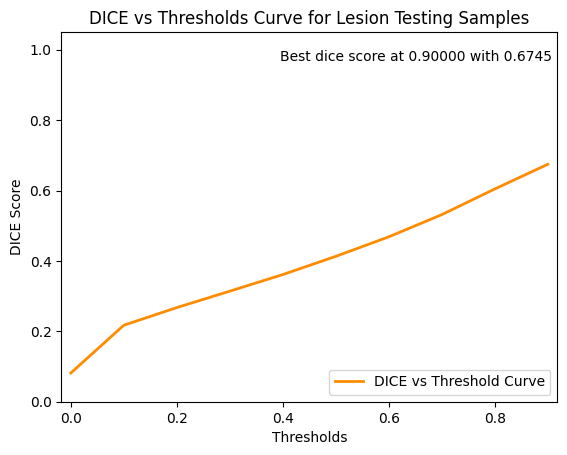

Computing AUROC:


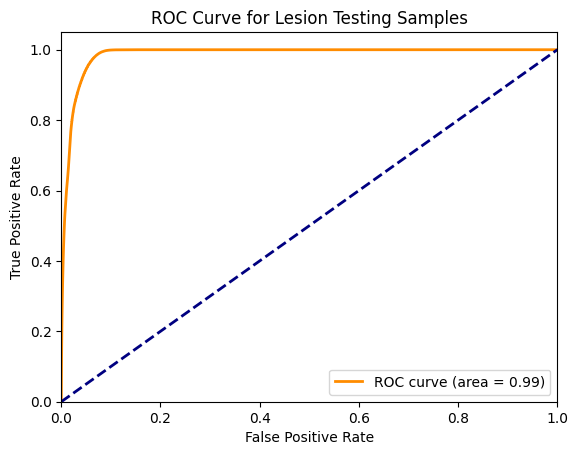

Computing AUPRC:


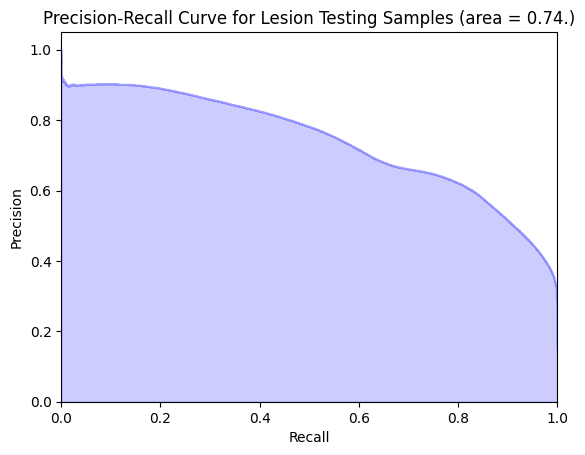

current epoch: 1 current L1 reconstruction error mean: 0.2441 AUROC: 0.9866 AUPRC: 0.7413 DICE score: 0.6745 Threshold: 0.9000 best L1 reconstruction error mean: 0.2441 at epoch: 1
----------
epoch 2/4
1/19, train_loss: 0.0981
2/19, train_loss: 0.0992
3/19, train_loss: 0.0970
4/19, train_loss: 0.0969
5/19, train_loss: 0.0961
6/19, train_loss: 0.0933
7/19, train_loss: 0.0944
8/19, train_loss: 0.0928
9/19, train_loss: 0.0916
10/19, train_loss: 0.0895
11/19, train_loss: 0.0884
12/19, train_loss: 0.0878
13/19, train_loss: 0.0887
14/19, train_loss: 0.0861
15/19, train_loss: 0.0867
16/19, train_loss: 0.0872
17/19, train_loss: 0.0833
18/19, train_loss: 0.0842
19/19, train_loss: 0.0811
epoch 2 average loss: 0.0907
Computing DICE:


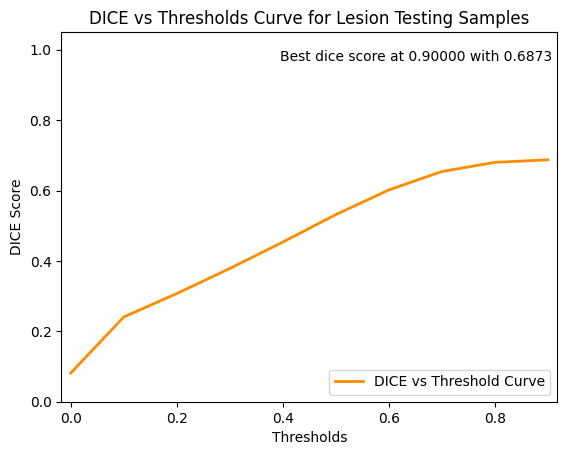

Computing AUROC:


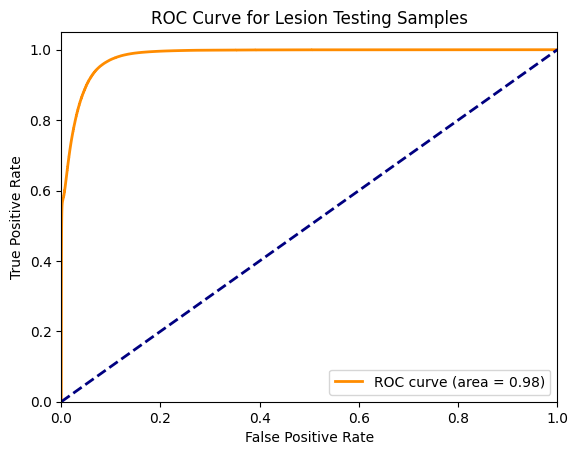

Computing AUPRC:


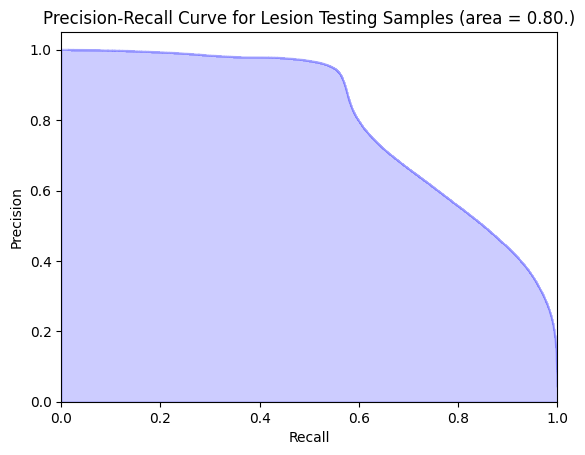

current epoch: 2 current L1 reconstruction error mean: 0.2126 AUROC: 0.9832 AUPRC: 0.8030 DICE score: 0.6873 Threshold: 0.9000 best L1 reconstruction error mean: 0.2126 at epoch: 2
----------
epoch 3/4
1/19, train_loss: 0.0839
2/19, train_loss: 0.0835
3/19, train_loss: 0.0830
4/19, train_loss: 0.0809
5/19, train_loss: 0.0803
6/19, train_loss: 0.0805
7/19, train_loss: 0.0789
8/19, train_loss: 0.0784
9/19, train_loss: 0.0765
10/19, train_loss: 0.0799
11/19, train_loss: 0.0763
12/19, train_loss: 0.0732
13/19, train_loss: 0.0754
14/19, train_loss: 0.0759
15/19, train_loss: 0.0758
16/19, train_loss: 0.0763
17/19, train_loss: 0.0754
18/19, train_loss: 0.0730
19/19, train_loss: 0.0717
epoch 3 average loss: 0.0778
Computing DICE:


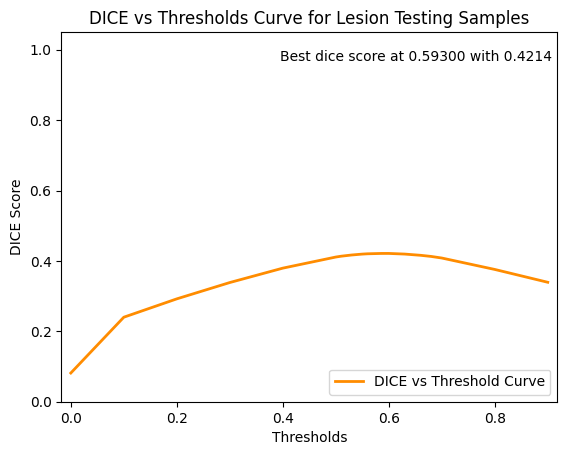

Computing AUROC:


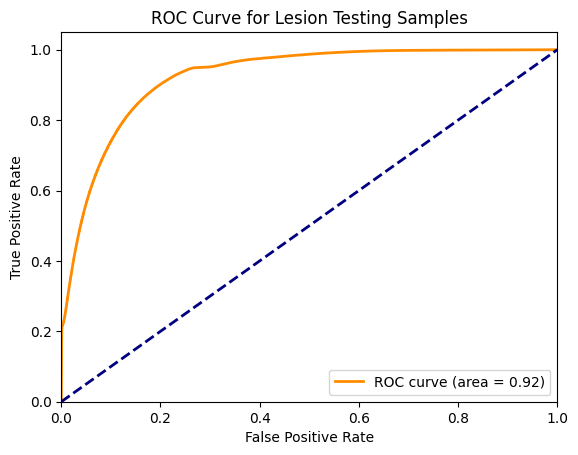

Computing AUPRC:


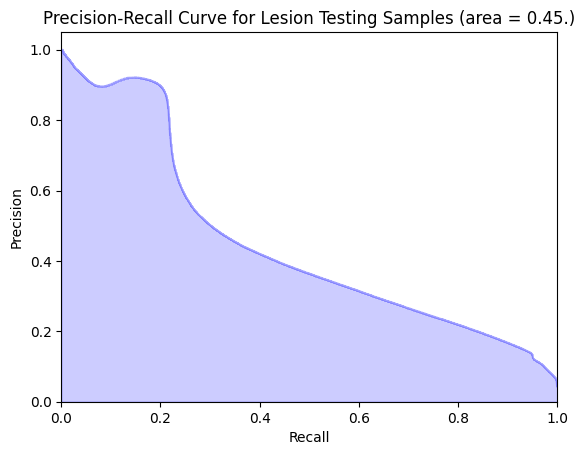

current epoch: 3 current L1 reconstruction error mean: 0.1947 AUROC: 0.9227 AUPRC: 0.4513 DICE score: 0.4214 Threshold: 0.5930 best L1 reconstruction error mean: 0.1947 at epoch: 3
----------
epoch 4/4
1/19, train_loss: 0.0728
2/19, train_loss: 0.0714
3/19, train_loss: 0.0721
4/19, train_loss: 0.0703
5/19, train_loss: 0.0687
6/19, train_loss: 0.0691
7/19, train_loss: 0.0673
8/19, train_loss: 0.0670
9/19, train_loss: 0.0688
10/19, train_loss: 0.0689
11/19, train_loss: 0.0689
12/19, train_loss: 0.0682
13/19, train_loss: 0.0667
14/19, train_loss: 0.0654
15/19, train_loss: 0.0639
16/19, train_loss: 0.0654
17/19, train_loss: 0.0655
18/19, train_loss: 0.0635
19/19, train_loss: 0.0655
epoch 4 average loss: 0.0679
Computing DICE:


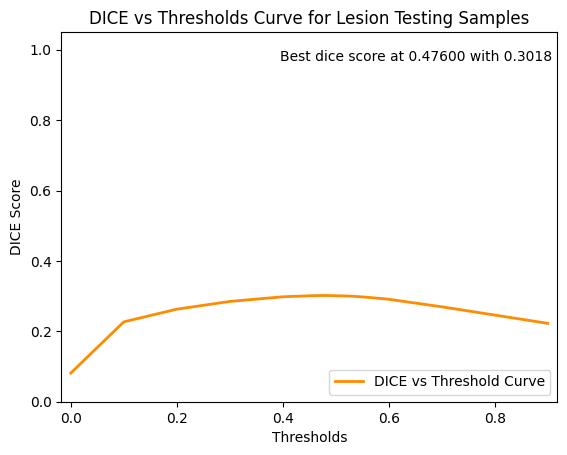

Computing AUROC:


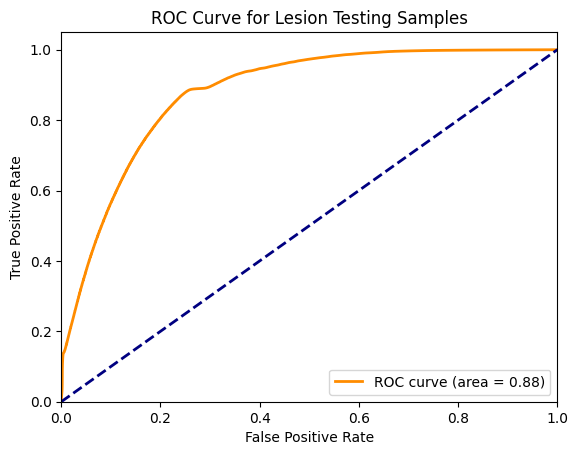

Computing AUPRC:


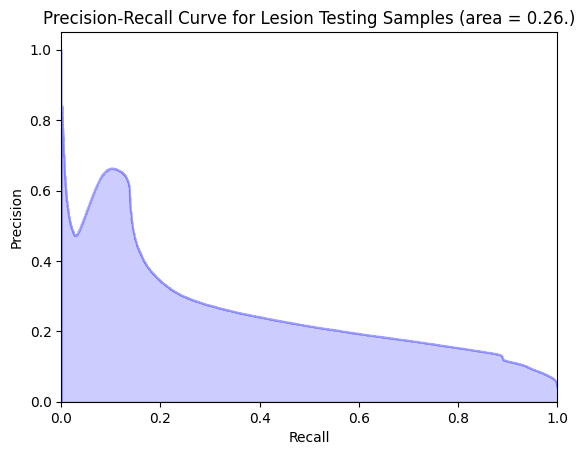

current epoch: 4 current L1 reconstruction error mean: 0.1846 AUROC: 0.8778 AUPRC: 0.2646 DICE score: 0.3018 Threshold: 0.4760 best L1 reconstruction error mean: 0.1846 at epoch: 4
train completed, best_metric: 0.1846 at epoch: 4
Saved model at C:\Users\irose\AppData\Local\Temp\tmpv6xz2p11\ae_model.pth.


In [533]:
best_metric = None
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
val_loss_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data, ground_truths in train_loader:
        step += 1
        inputs = batch_data.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{int(np.ceil(len(train_ds) / train_loader.batch_size))}, "f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y_mask = torch.tensor([], dtype=torch.long, device=device)
            y_true = torch.tensor([], dtype=torch.long, device=device)

            for val_data, ground_truths in val_loader:
                val_images = val_data.to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y_true = torch.cat([y_true, val_images], dim=0)
                y_mask = torch.cat([y_mask, ground_truths], dim=0)
                loss = loss_function(y_pred, y_true)
                val_loss_values.append(loss.item())
            
            y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
            y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
            y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])
            y_diffs = np.abs(y_true_np-y_pred_np)

            reconstruction_err = np.sum(val_loss_values)
            avg_reconstruction_err = np.mean(val_loss_values)
            metric_values.append(avg_reconstruction_err)
            if best_metric == None or avg_reconstruction_err < best_metric:
                best_metric = avg_reconstruction_err
                best_metric_epoch = epoch + 1
            
           
            print("Computing DICE:")
            folder = "images"
            if not os.path.exists(folder):
                os.mkdir(folder)
            diceScore,diceThreshold = compute_dice_curve_recursive(
                y_diffs, y_mask_np,
                plottitle="DICE vs Thresholds Curve for Lesion Testing Samples",
                filename=os.path.join(folder, f'dicePC_{epoch+1}.png'),
                granularity=10
            )
            print("Computing AUROC:")
            diff_auc, _fpr, _tpr, _threshs = compute_roc(y_diffs.flatten(), y_mask_np.astype(bool).flatten(),
                                                                            plottitle="ROC Curve for Lesion Testing Samples",
                                                                            filename=os.path.join(folder, f'rocPC_{epoch+1}.png'))

            print("Computing AUPRC:")
            diff_auprc, _precisions, _recalls, _threshs = compute_prc(
                y_diffs.flatten(),
                y_mask_np.astype(bool).flatten(),
                plottitle="Precision-Recall Curve for Lesion Testing Samples",
                filename=os.path.join(folder, f'prcPC_{epoch+1}.png')
            )

            del y_mask_np,y_true_np,y_pred_np
            print(
                f"current epoch: {epoch + 1}",
                f"\ncurrent L1 reconstruction error mean: {avg_reconstruction_err:.4f}",
                f"\nAUROC: {diff_auc:.4f}",
                f"\nAUPRC: {diff_auprc:.4f}",
                f"\nDICE score: {diceScore:.4f}",
                f"\nThreshold: {diceThreshold:.4f}",
                f"\nbest L1 reconstruction error mean: {best_metric:.4f}",
                f"\nat epoch: {best_metric_epoch}"
            )

print(f"train completed, best_metric: {best_metric:.4f} "f"at epoch: {best_metric_epoch}")
modelsavedloc = os.path.join(root_dir,"ae_model.pth")
torch.save(model.state_dict(), modelsavedloc)
print(f"Saved model at {modelsavedloc}.")

In [496]:
model = AutoEnc()
model.load_state_dict(torch.load('ae_model.pth'))

c:\Users\irose\miniconda3\envs\mriproj\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

Computing DICE:


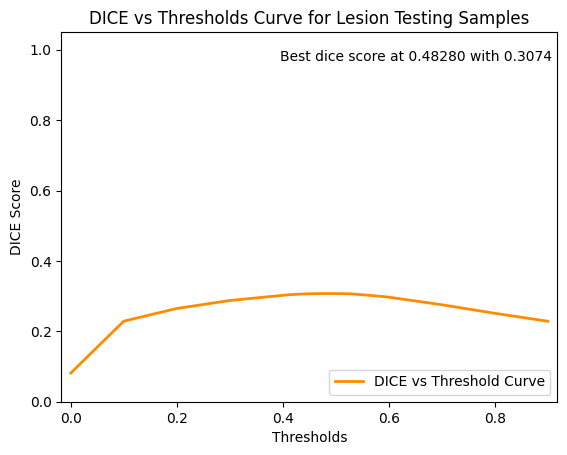

Computing AUROC:


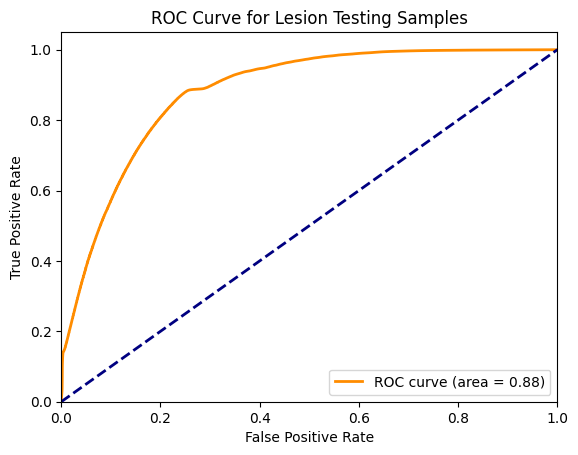

Computing AUPRC:


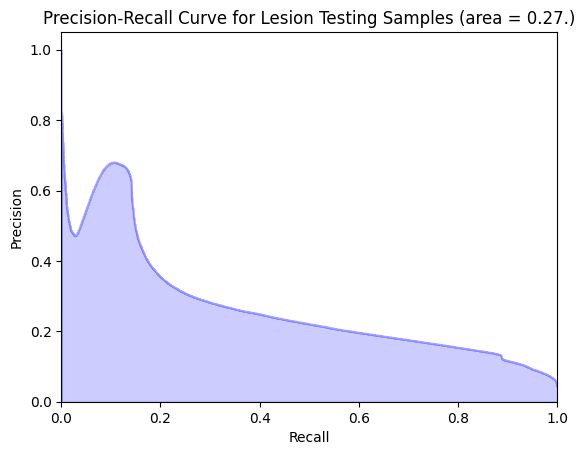

current epoch: 4 current L1 reconstruction error mean: 0.1524 AUROC: 0.8794 AUPRC: 0.2707 DICE score: 0.3074 Threshold: 0.4828 at epoch: 4


In [535]:
best_metric = None
test_loss_values = []
model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y_mask = torch.tensor([], dtype=torch.long, device=device)
    y_true = torch.tensor([], dtype=torch.long, device=device)

    for test_data, ground_truths in test_loader:
        test_images = test_data.to(device)
        y_pred = torch.cat([y_pred, model(test_images)], dim=0)
        y_true = torch.cat([y_true, test_images], dim=0)
        y_mask = torch.cat([y_mask, ground_truths], dim=0)
        loss = loss_function(y_pred, y_true)
        test_loss_values.append(loss.item())
    
    y_mask_np = np.array([i.numpy() for i in decollate_batch(y_mask, detach=False)])
    y_true_np = np.array([i.numpy() for i in decollate_batch(y_true,detach=False)])
    y_pred_np = np.array([i.numpy() for i in decollate_batch(y_pred)])
    y_diffs = np.abs(y_true_np-y_pred_np)

    reconstruction_err = np.sum(test_loss_values)
    avg_reconstruction_err = np.mean(test_loss_values)

    
    
    print("Computing DICE:")
    folder = "images"
    if not os.path.exists(folder):
        os.mkdir(folder)
    diceScore,diceThreshold = compute_dice_curve_recursive(
        y_diffs, y_mask_np,
        plottitle="DICE vs Thresholds Curve for Lesion Testing Samples",
        filename=os.path.join(folder, f'dicePC_test.png'),
        granularity=10
    )
    print("Computing AUROC:")
    diff_auc, _fpr, _tpr, _threshs = compute_roc(y_diffs.flatten(), y_mask_np.astype(bool).flatten(),
                                                                    plottitle="ROC Curve for Lesion Testing Samples",
                                                                    filename=os.path.join(folder, f'rocPC_test.png'))

    print("Computing AUPRC:")
    diff_auprc, _precisions, _recalls, _threshs = compute_prc(
        y_diffs.flatten(),
        y_mask_np.astype(bool).flatten(),
        plottitle="Precision-Recall Curve for Lesion Testing Samples",
        filename=os.path.join(folder, f'prcPC_test.png')
    )

    del y_mask_np,y_true_np,y_pred_np
    print(
        f"current epoch: {epoch + 1}",
        f"\ncurrent L1 reconstruction error mean: {avg_reconstruction_err:.4f}",
        f"\nAUROC: {diff_auc:.4f}",
        f"\nAUPRC: {diff_auprc:.4f}",
        f"\nDICE score: {diceScore:.4f}",
        f"\nThreshold: {diceThreshold:.4f}",
        f"\nat epoch: {best_metric_epoch}"
    )

In [467]:
h=64
stride=1
padding=0
dilation=1
kernel_size=5
output_padding=0

print((h-1)*stride-2*padding+dilation*(kernel_size-1)+output_padding+1)
print(((h+2*padding-dilation*(kernel_size-1)-1)/(stride))+1)

68
